# TSNE on Amazon Food Reviews - Assignment by Shobhit Gupta

We will apply TSNE method to each of the following to reduce the dimensionality and check after multiple runs that the overall distribution is constant

In [2]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
import re

# using the SQLite Table to read data.
con = sqlite3.connect('C:/Users/Shobhit/Desktop/amazon-fine-food-reviews/database.sqlite')

df_pos = pd.read_sql_query("""SELECT * FROM Reviews WHERE Score = 4 or Score = 5 limit 2000""",con) #selecting 2k +ve reviews and storing them in a dataframe

df_neg = pd.read_sql_query("""SELECT * FROM Reviews WHERE Score = 1 or Score = 2 limit 2000""",con) #selecting 2k -ve reviews and storing them in a dataframe

lof = [df_pos, df_neg]
fin = pd.concat(lof)   #concatenating the two dataframes to get our 4k sampledata

def posneg(x):
    if x == 5 or x == 4:
        return "positive"
    return "negative"

actScore = fin['Score']
pn = actScore.map(posneg)   #coverting into 'positive' and 'negative'

fin['Score'] = pn
fin.shape

(4000, 10)

In [3]:
fin

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
2,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...
3,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,positive,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...
4,7,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0,0,positive,1340150400,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...
5,8,B006K2ZZ7K,A3JRGQVEQN31IQ,Pamela G. Williams,0,0,positive,1336003200,"Wonderful, tasty taffy",This taffy is so good. It is very soft and ch...
6,9,B000E7L2R4,A1MZYO9TZK0BBI,R. James,1,1,positive,1322006400,Yay Barley,Right now I'm mostly just sprouting this so my...
7,10,B00171APVA,A21BT40VZCCYT4,Carol A. Reed,0,0,positive,1351209600,Healthy Dog Food,This is a very healthy dog food. Good for thei...
8,11,B0001PB9FE,A3HDKO7OW0QNK4,Canadian Fan,1,1,positive,1107820800,The Best Hot Sauce in the World,I don't know if it's the cactus or the tequila...
9,12,B0009XLVG0,A2725IB4YY9JEB,"A Poeng ""SparkyGoHome""",4,4,positive,1282867200,"My cats LOVE this ""diet"" food better than thei...",One of my boys needed to lose some weight and ...


In [3]:
# find sentences containing HTML tags
i=0;
for sent in fin['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

8
I don't know if it's the cactus or the tequila or just the unique combination of ingredients, but the flavour of this hot sauce makes it one of a kind!  We picked up a bottle once on a trip we were on and brought it back home with us and were totally blown away!  When we realized that we simply couldn't find it anywhere in our city we were bummed.<br /><br />Now, because of the magic of the internet, we have a case of the sauce and are ecstatic because of it.<br /><br />If you love hot sauce..I mean really love hot sauce, but don't want a sauce that tastelessly burns your throat, grab a bottle of Tequila Picante Gourmet de Inclan.  Just realize that once you taste it, you will never want to use any other sauce.<br /><br />Thank you for the personal, incredible service!


-- Stop words removal

-- Lemmatization

-- Snowball stemming

In [34]:
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)

{"you'll", 't', "don't", 'that', "won't", "isn't", "needn't", 'each', 'it', 'she', 'most', 'who', 'all', "hasn't", 'up', 'her', "shouldn't", "shan't", 'had', 'yourselves', 'its', 'whom', 'into', 'does', 'other', 'yours', 'while', 'm', 'ain', 'now', "weren't", 'between', 'some', 'doesn', 'such', 'we', 'himself', 'against', 'is', 'which', 'a', 'if', 'but', 'd', 'your', 'did', 'hers', 'not', 'what', 'too', 'i', 'by', 'has', 'ourselves', 'out', "couldn't", 'itself', 'until', 'shan', 'weren', 'you', 'theirs', 'be', 'should', 'at', "you've", 'those', 'nor', 'own', 'isn', 'don', "haven't", 'me', "you'd", 's', 'needn', "she's", 'he', "aren't", 'so', 'will', "wouldn't", 'any', 'being', 'll', 'my', 'above', 'myself', 'they', 'are', 'there', 'why', 'from', 'hasn', 'about', 'no', 'both', 'same', 'in', 'couldn', 'only', "mightn't", 've', 'can', "wasn't", 'won', "didn't", "you're", 'during', 'ours', 'shouldn', 'more', 'under', "that'll", 'after', 'below', 'how', 'off', 'didn', "doesn't", 'than', 'an

In [5]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in fin['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (fin['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(fin['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [8]:
fin['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 

In [9]:
fin.head()

# store final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
fin.to_sql('Reviews', conn, flavor=None, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

#  TSNE on BOW (Bag of words)

In [9]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
final_counts = count_vect.fit_transform(fin['Text'].values)

In [10]:
type(final_counts)

scipy.sparse.csr.csr_matrix

In [11]:
final_counts.get_shape()

(4000, 12505)

In [12]:
label = fin['Score']

In [38]:
from sklearn.manifold import TSNE
import seaborn as sns

tsne_model = TSNE(n_components=2, random_state=0)
tsne_data  = tsne_model.fit_transform(final_counts.toarray())

In [39]:
tsne_data.shape

(4000, 2)

In [40]:
# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, label)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2","Score"))

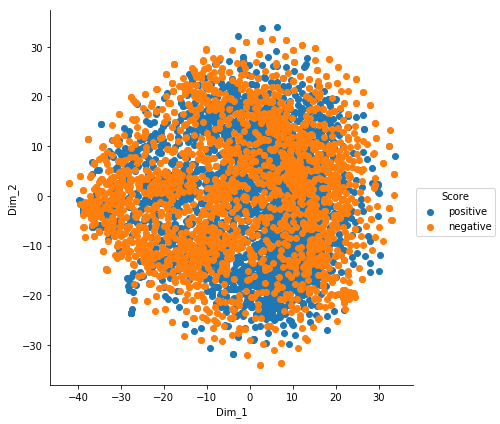

In [41]:
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="Score", size=6).map(plt.scatter, 'Dim_1','Dim_2').add_legend()
plt.show()

In [42]:
tsne_model = TSNE(n_components=2, random_state=0, perplexity = 50)
tsne_data  = tsne_model.fit_transform(final_counts.toarray())

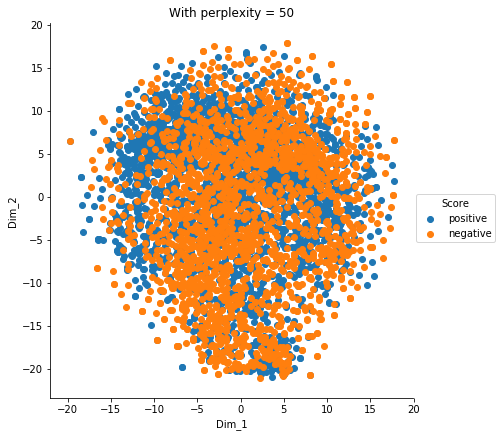

In [43]:
# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, label)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="Score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 50')
plt.show()

In [44]:
tsne_model = TSNE(n_components=2, random_state=0, perplexity = 50, n_iter = 5000)
tsne_data  = tsne_model.fit_transform(final_counts.toarray())

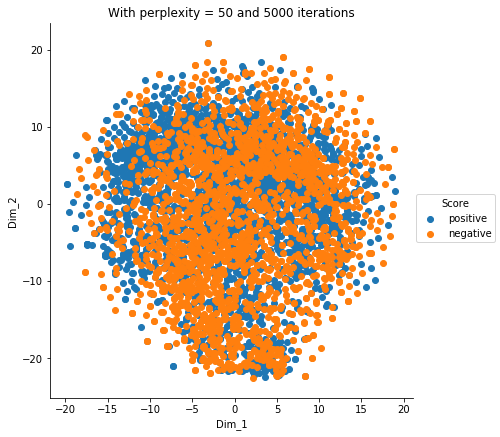

In [45]:
# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, label)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="Score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 50 and 5000 iterations')
plt.show()

In [59]:
tsne_model = TSNE(n_components=2, random_state=0, perplexity = 500, n_iter = 5000)
tsne_data  = tsne_model.fit_transform(final_counts.toarray())

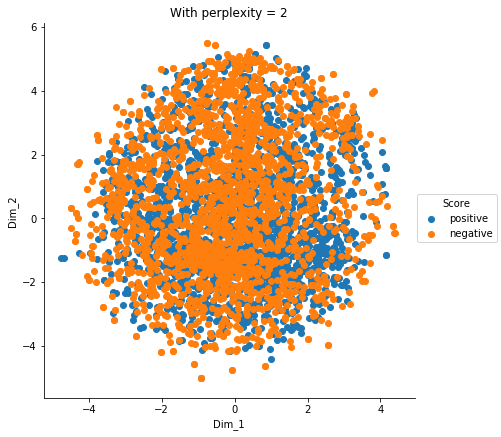

In [60]:
# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, label)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="Score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 500 and iterations = 5000')
plt.show()

##### Observation(s):  The changing values of perplexity and iterations have marginal difference on the TSNE plot in BOW.

# TSNE on Bi-gram, Tri-gram and n-gram

In [13]:
freq_dist_positive=nltk.FreqDist(all_positive_words)
freq_dist_negative=nltk.FreqDist(all_negative_words)
print("Most Common Positive Words : ",freq_dist_positive.most_common(20))
print("Most Common Negative Words : ",freq_dist_negative.most_common(20))

Most Common Positive Words :  [(b'chip', 929), (b'flavor', 896), (b'like', 868), (b'love', 744), (b'tast', 741), (b'good', 739), (b'great', 730), (b'one', 577), (b'use', 537), (b'tri', 534), (b'product', 516), (b'bag', 516), (b'food', 465), (b'make', 419), (b'get', 381), (b'tea', 367), (b'eat', 344), (b'realli', 343), (b'buy', 336), (b'coffe', 333)]
Most Common Negative Words :  [(b'tast', 1142), (b'like', 1092), (b'product', 971), (b'flavor', 765), (b'one', 678), (b'would', 640), (b'tri', 611), (b'coffe', 603), (b'use', 517), (b'good', 515), (b'buy', 492), (b'food', 481), (b'get', 464), (b'order', 428), (b'dont', 404), (b'even', 400), (b'bag', 397), (b'time', 371), (b'much', 361), (b'amazon', 358)]


In [14]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
count_vect = CountVectorizer(ngram_range=(1,2) ) #in scikit-learn
final_bigram_counts = count_vect.fit_transform(fin['Text'].values)


In [15]:
final_bigram_counts.get_shape()

(4000, 131283)

In [25]:
from sklearn.manifold import TSNE
import seaborn as sns

label1 = fin['Score']

In [ ]:
tsne_model1 = TSNE(n_components=2, random_state=0)
tsne_data1  = tsne_model1.fit_transform(final_bigram_counts.toarray())

In [21]:
print(tsne_data1.shape)

(4000, 2)


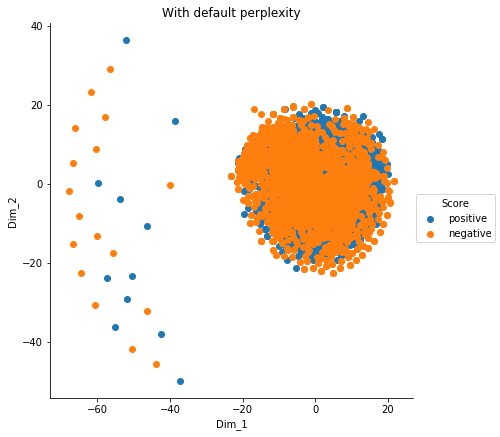

In [22]:
# creating a new data fram which help us in ploting the result data
tsne_data1 = np.vstack((tsne_data1.T, label1)).T
tsne_df1 = pd.DataFrame(data=tsne_data1, columns=("Dim_1", "Dim_2", "Score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df1, hue="Score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With default perplexity')
plt.show()

In [27]:
tsne_model1 = TSNE(n_components=2, random_state=0, perplexity = 2)
tsne_data1  = tsne_model1.fit_transform(final_bigram_counts.toarray())

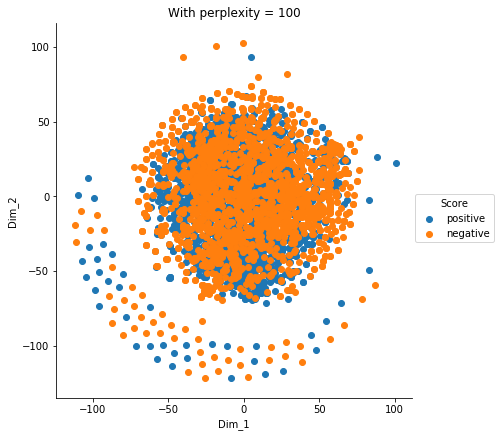

In [28]:
# creating a new data fram which help us in ploting the result data
tsne_data1 = np.vstack((tsne_data1.T, label1)).T
tsne_df1 = pd.DataFrame(data=tsne_data1, columns=("Dim_1", "Dim_2", "Score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df1, hue="Score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 2')
plt.show()

##### Observation(s): The points which are separate from the round cluster of points tend to sphere around the latter when peplexity value is   reduced to 2

In [29]:
tsne_model1 = TSNE(n_components=2, random_state=0, perplexity = 200)
tsne_data1  = tsne_model1.fit_transform(final_bigram_counts.toarray())

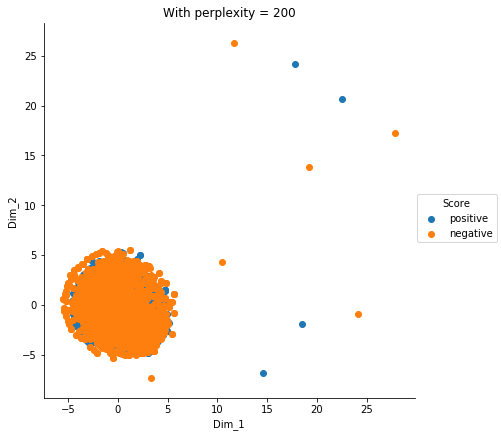

In [30]:
# creating a new data fram which help us in ploting the result data
tsne_data1 = np.vstack((tsne_data1.T, label1)).T
tsne_df1 = pd.DataFrame(data=tsne_data1, columns=("Dim_1", "Dim_2", "Score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="Score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 200')
plt.show()

##### Observation(s):  With perplexity = 200, the points form a very dense cluster. A few points however are separated

# TSNE on TF-IDF

In [41]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(fin['Text'].values)

In [42]:
final_tf_idf.get_shape()

(4000, 131283)

In [40]:
tsne_model2 = TSNE(n_components=2, random_state=0)
tsne_data2  = tsne_model2.fit_transform(final_tf_idf.toarray())

In [41]:
tsne_data2.shape

(4000, 2)

In [13]:
label2 = fin['Score']

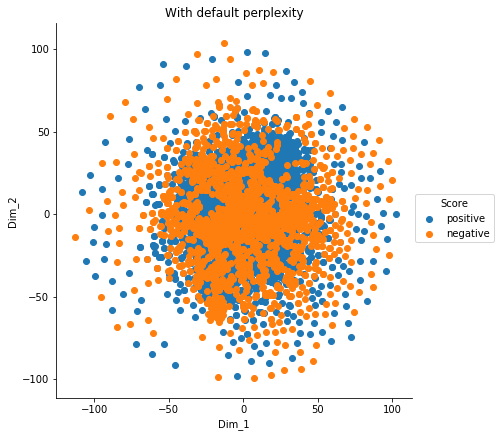

In [42]:
# creating a new data fram which help us in ploting the result data

tsne_data2 = np.vstack((tsne_data2.T, label2)).T
tsne_df2 = pd.DataFrame(data=tsne_data2, columns=("Dim_1", "Dim_2", "Score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df2, hue="Score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With default perplexity')
plt.show()

In [11]:
tsne_model2 = TSNE(n_components=2, random_state=0, perplexity = 100)
tsne_data2  = tsne_model2.fit_transform(final_tf_idf.toarray())

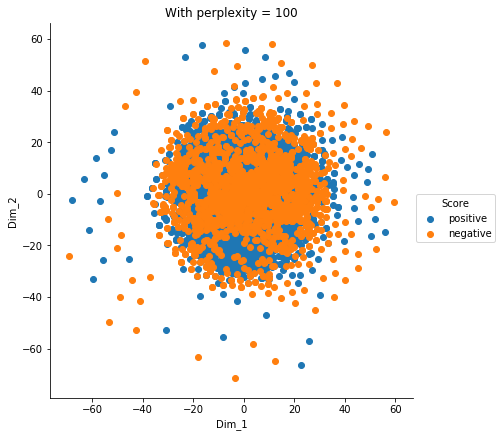

In [14]:
tsne_data2 = np.vstack((tsne_data2.T, label2)).T
tsne_df2 = pd.DataFrame(data=tsne_data2, columns=("Dim_1", "Dim_2", "Score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df2, hue="Score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 100')
plt.show()

In [15]:
tsne_model2 = TSNE(n_components=2, random_state=0, perplexity = 100, n_iter = 3000)
tsne_data2  = tsne_model2.fit_transform(final_tf_idf.toarray())

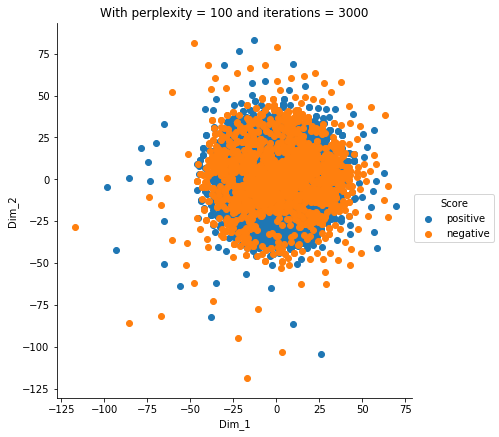

In [16]:
tsne_data2 = np.vstack((tsne_data2.T, label2)).T
tsne_df2 = pd.DataFrame(data=tsne_data2, columns=("Dim_1", "Dim_2", "Score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df2, hue="Score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 100 and iterations = 3000')
plt.show()

##### Observations(s): 1) Increasing/Decreasing value of perplexity/iteration have little or no effect on the distribution of points.
#####                             2) However, with default perplexity, the points tend to spread. 

# TSNE on Avg Word2Vec

In [6]:
# Train your own Word2Vec model using your own text corpus
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
i=0
list_of_sent=[]
for sent in fin['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

C:\Users\Shobhit\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [7]:
print(fin['Text'].values[0])
print("*****************************************************************")
print(list_of_sent[0])

I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.
*****************************************************************
['i', 'have', 'bought', 'several', 'of', 'the', 'vitality', 'canned', 'dog', 'food', 'products', 'and', 'have', 'found', 'them', 'all', 'to', 'be', 'of', 'good', 'quality', 'the', 'product', 'looks', 'more', 'like', 'a', 'stew', 'than', 'a', 'processed', 'meat', 'and', 'it', 'smells', 'better', 'my', 'labrador', 'is', 'finicky', 'and', 'she', 'appreciates', 'this', 'product', 'better', 'than', 'most']


In [8]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4) 

In [13]:
words = list(w2v_model.wv.vocab)
print(len(words))

3777


In [9]:
sent_vectors = []; 
for sent in list_of_sent: 
    sent_vec = np.zeros(50)
    cnt_words =0; 
    for word in sent: 
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)

In [19]:
snt = np.asarray(sent_vectors)

In [25]:
snt_s = sparse.csr_matrix(snt) # Converting snt into a sparse csr_matrix

In [26]:
type(snt_s)

scipy.sparse.csr.csr_matrix

In [35]:
snt_s.shape

(4000, 50)

In [28]:
from sklearn.manifold import TSNE
import seaborn as sns

tsne_model3 = TSNE(n_components=2, random_state=0, perplexity = 100, n_iter = 3000)
tsne_data3  = tsne_model3.fit_transform(snt_s.toarray())

In [30]:
tsne_data3.shape

(4000, 2)

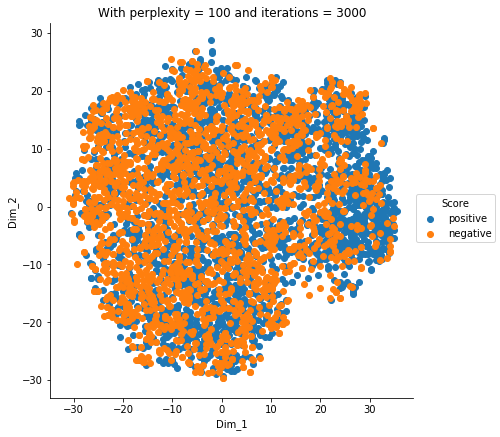

In [31]:
tsne_data3 = np.vstack((tsne_data3.T, label3)).T
tsne_df3 = pd.DataFrame(data=tsne_data3, columns=("Dim_1", "Dim_2", "Score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df3, hue="Score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 100 and iterations = 3000')
plt.show()

In [32]:
tsne_model3 = TSNE(n_components=2, random_state=0)
tsne_data3  = tsne_model3.fit_transform(snt_s.toarray())

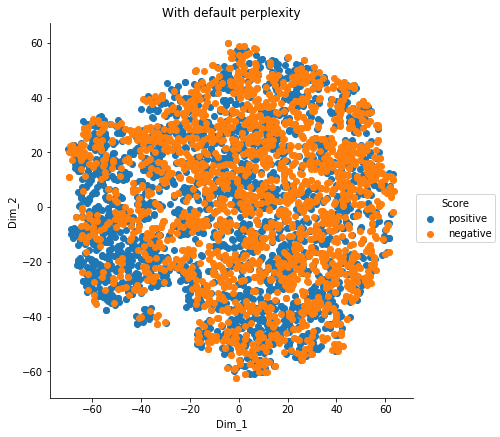

In [33]:
tsne_data3 = np.vstack((tsne_data3.T, label3)).T
tsne_df3 = pd.DataFrame(data=tsne_data3, columns=("Dim_1", "Dim_2", "Score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df3, hue="Score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With default perplexity')
plt.show()

In [38]:
tsne_model3 = TSNE(n_components=2, random_state=0, perplexity = 500)
tsne_data3  = tsne_model3.fit_transform(snt_s.toarray())

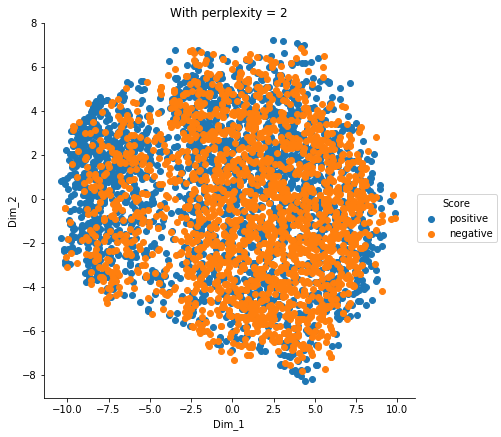

In [39]:
tsne_data3 = np.vstack((tsne_data3.T, label3)).T
tsne_df3 = pd.DataFrame(data=tsne_data3, columns=("Dim_1", "Dim_2", "Score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df3, hue="Score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 2')
plt.show()

##### Observation(s):  The changing values of perplexity and iterations have marginal difference on the TSNE plot in Avg W2V.

# TSNE on TF-IDF W2V 

In [45]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tfidf)
            weight_sum += tfidf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

In [47]:
t = np.asarray(tfidf_sent_vectors)

tp = sparse.csr_matrix(t)

tp.shape

(4000, 50)

In [48]:
tsne_model4 = TSNE(n_components=2, random_state=0)
tsne_data4  = tsne_model4.fit_transform(tp.toarray())

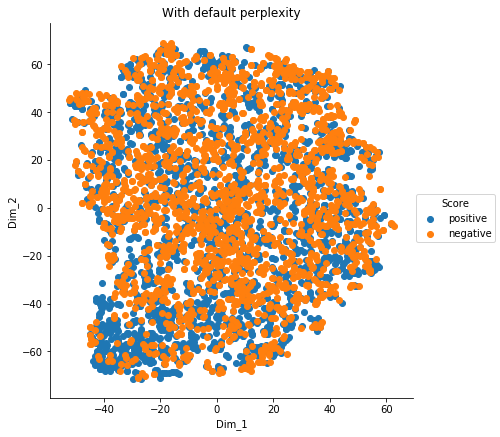

In [49]:
tsne_data4 = np.vstack((tsne_data4.T, label3)).T
tsne_df4 = pd.DataFrame(data=tsne_data4, columns=("Dim_1", "Dim_2", "Score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df4, hue="Score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With default perplexity')
plt.show()

In [50]:
tsne_model4 = TSNE(n_components=2, random_state=0, perplexity = 100)
tsne_data4  = tsne_model4.fit_transform(tp.toarray())

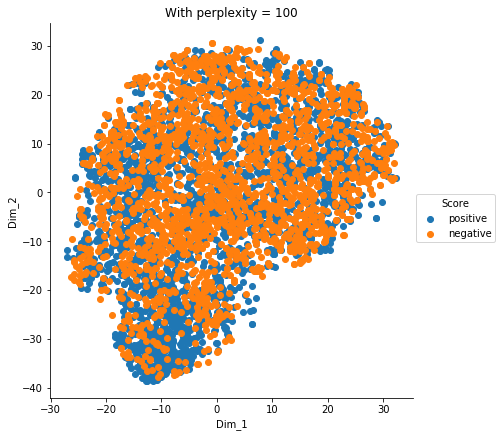

In [51]:
tsne_data4 = np.vstack((tsne_data4.T, label3)).T
tsne_df4 = pd.DataFrame(data=tsne_data4, columns=("Dim_1", "Dim_2", "Score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df4, hue="Score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 100')
plt.show()

In [52]:
tsne_model4 = TSNE(n_components=2, random_state=0, perplexity = 100, n_iter = 5000)
tsne_data4  = tsne_model4.fit_transform(tp.toarray())

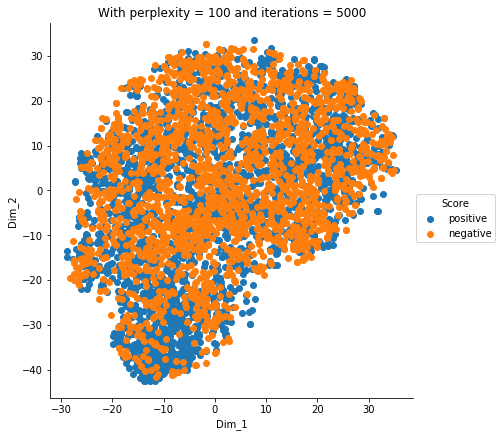

In [53]:
tsne_data4 = np.vstack((tsne_data4.T, label3)).T
tsne_df4 = pd.DataFrame(data=tsne_data4, columns=("Dim_1", "Dim_2", "Score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df4, hue="Score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 100 and iterations = 5000')
plt.show()

### Conclusion: We observe that t - SNE reduces the dimensionality of datapoints to huge extent efficiently in all four cases: BOW, TF-IDF, Average Word2Vec and TF-IDF Word2vec.